**XLNet**

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade "urllib3==1.25.4" awscli

     |████████████████████████████████| 133kB 13.6MB/s 
     |████████████████████████████████| 3.5MB 31.6MB/s 
     |████████████████████████████████| 552kB 53.3MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
     |████████████████████████████████| 7.0MB 5.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: rsa 4.6
    Uninstalling rsa-4.6:
      Successfully uninstalled rsa-4.6
  Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16


In [3]:
!pip install transformers


     |████████████████████████████████| 1.4MB 14.9MB/s 
     |████████████████████████████████| 890kB 44.1MB/s 
     |████████████████████████████████| 2.9MB 52.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=0f7c0ff3697298c883c93d0971356dfc077c6bb067823828331b17afff5758b6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import csv
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler

from transformers import XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer
from transformers import AdamW,get_linear_schedule_with_warmup
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.metrics import matthews_corrcoef, f1_score

**Load Dataset**

In [5]:
df = pd.read_csv('drive/My Drive/255 project/Clothing_Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


**Data Preprocessing**

In [6]:
df.dropna()
df = df.loc[:, ['Review Text', 'Rating']]
df.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


In [ ]:
def get_sentiment(value):
    if value > 3:
        return 1
    else:
        return 0

In [ ]:
df['Sentiment'] = df['Rating'].apply(get_sentiment)
df=df.loc[:,['Review Text','Sentiment']]

In [ ]:
df=df[~df['Review Text'].isnull()]
df.isna().sum()

Review Text    0
Sentiment      0
dtype: int64

In [ ]:
df.columns=['Text','Sentiment']

In [ ]:
df.head(5)

,Text,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [ ]:
from sklearn.model_selection import train_test_split
# train_df.shape, val_df.shape
train_df, val_df = train_test_split(df, test_size=0.5, random_state=101)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=101)

train_df.shape, val_df.shape, test_df.shape

((11320, 2), (5660, 2), (5661, 2))

In [ ]:

save_dir = Path('/content/drive/My Drive/Colab Notebooks/Amazon Reviews')
train_df.to_csv(str(save_dir / "train.csv"), index=False)
val_df.to_csv(str(save_dir / "dev.csv"), index=False)
test_df.to_csv(str(save_dir / "test.csv"), index=False)

In [ ]:

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [ ]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines
          
class AmazonProcessor(DataProcessor):
    """Processor for the Amazon Reviews data set."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.csv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.csv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test.csv")), "test")

    def get_labels(self):
        """See base class."""
        return [0, 1]

    #Hack to be compatible with the existing code in transformers library
    def _read_tsv(self, file_path):
        return pd.read_csv(file_path).values.tolist()

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
          # print(f'line: {line}')
          if i == 0:
              continue
          guid = "%s-%s" % (set_type, i)
          text_a = str(line[0])
           # text_b = None
          label = line[1]
          examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [ ]:
def simple_accuracy(preds, labels):
  return (preds == labels).mean()
  
def acc_and_f1(preds, labels):
  acc = simple_accuracy(preds, labels)
  f1 = f1_score(y_true=labels, y_pred=preds)
  return {
      "acc": acc,
      "f1": f1,
      "acc_and_f1": (acc + f1) / 2,
  }


def f1_macro(preds, labels):
  return f1_score(y_true=labels, y_pred=preds, average='macro')
  
def compute_metrics(task_name, preds, labels):
  assert len(preds) == len(labels)
  if task_name == "amazon":
    return {"acc": simple_accuracy(preds, labels)}
  else:
    raise KeyError(task_name)

In [ ]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [ ]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode,
                                 cls_token_at_end=False, pad_on_left=False,
                                 cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                 sequence_a_segment_id=0, sequence_b_segment_id=1,
                                 cls_token_segment_id=1, pad_token_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label : i for i, label in enumerate(label_list)}
  
    features = []
    for (ex_index, example) in enumerate(examples):
        # print(f'ex_index:{ex_index}')
        # print(f'example:{example.guid}')
        # print(f'example:{example.text_a}')
        # print(f'example:{example.text_b}')
        # print(f'example.label:{example.label}')


        tokens_a = tokenizer.tokenize(example.text_a)
        # print(f'tokens_a:{tokens_a}')

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack son ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0   0    0    0   0    0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = tokens_a + [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        if cls_token_at_end:
            tokens = tokens + [cls_token]
            segment_ids = segment_ids + [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        # print(f'tokens:{tokens}')

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if output_mode == "classification":
          # print(f'label_map:{label_map}')
          # print(f'example.label:{example.label}')
          label_id = label_map[example.label]
          # print(f'lable_id:{label_id}')
        elif output_mode == "regression":
          label_id = float(example.label)
        else:
          raise KeyError(output_mode)

        # print(f'input_ids:{input_ids}')
        # print(f'input_mask:{input_mask}')
        # print(f'segment_ids:{segment_ids}')
        # print(f'label_id:{label_id}')

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
        


    return features

In [ ]:
processor = AmazonProcessor()
label_list = processor.get_labels()
num_labels = len(label_list)

In [ ]:
% pip install sentencepiece

In [ ]:
#XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer
config = XLNetConfig.from_pretrained('xlnet-base-cased', num_labels=num_labels)
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)
#model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', config=config)

In [ ]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', config=config)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
def load_and_cache_examples(tokenizer, dataset='train'):  
  if dataset == "train":
      examples = processor.get_train_examples(data_dir)
  elif dataset == "dev":
      examples = processor.get_dev_examples(data_dir)
  else:
      examples = processor.get_test_examples(data_dir)
  
  features = convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, output_mode,
            cls_token_at_end=True,            # xlnet has a cls token at the end
            cls_token=tokenizer.cls_token,
            sep_token=tokenizer.sep_token,
            cls_token_segment_id=2,
            pad_on_left=True,                 # pad on the left for xlnet
            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
            pad_token_segment_id=4)
  # Convert to Tensors and build dataset
  all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
  all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
  all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
  if output_mode == "classification":
      all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
  elif output_mode == "regression":
      all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

  dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  return dataset
  

In [ ]:
output_mode = 'classification'
max_seq_length = 128
batch_size = 8
max_grad_norm = 1.0
gradient_accumulation_steps=2
num_train_epochs=3
weight_decay=0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:

learning_rate = 2e-5
adam_epsilon = 1e-8
warmup_steps = 0

In [ ]:
def train(train_dataset, model, tokenizer):
  """ Train the model """
  train_sampler = RandomSampler(train_dataset)
  train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
  t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
  # Prepare optimizer and schedule (linear warmup and decay)
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
      ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
  
  global_step = 0
  tr_loss, logging_loss = 0.0, 0.0
  model.zero_grad()
  train_iterator = tqdm_notebook(range(int(num_train_epochs)), desc="Epoch")
  set_seed(42)
  for _ in train_iterator:
    epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      model.train()
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],       # XLM and RoBERTa don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)

   # add code to calculate the acc
      tmp_eval_loss, logits = outputs[:2]
      if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
      else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

      loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
      if gradient_accumulation_steps > 1:
        loss = loss / gradient_accumulation_steps
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      tr_loss += loss.item()
      if (step + 1) % gradient_accumulation_steps == 0:
          scheduler.step()  # Update learning rate schedule
          optimizer.step()
          model.zero_grad()
          global_step += 1
    if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
      preds = np.squeeze(preds)
    result = compute_metrics("amazon", preds, out_label_ids)
    print(results)
  return global_step, tr_loss / global_step, result

In [ ]:
def train_validation(train_dataset, validation_dataset, model, tokenizer):
  """ Train the model """
  train_sampler = RandomSampler(train_dataset)
  train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
  t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
  # Prepare optimizer and schedule (linear warmup and decay)
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
      ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
  
  global_step = 0
  tr_loss, logging_loss = 0.0, 0.0
  model.zero_grad()

  train_iterator = tqdm_notebook(range(int(num_train_epochs)), desc="Epoch")
  set_seed(42)

  best_accuracy = 0

  for _ in train_iterator:
    preds = None
    epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      model.train()
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],       # XLM and RoBERTa don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
    # add code to calculate the acc
      tmp_eval_loss, logits = outputs[:2]
      if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
      else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

      loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
      if gradient_accumulation_steps > 1:
        loss = loss / gradient_accumulation_steps
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      tr_loss += loss.item()
      if (step + 1) % gradient_accumulation_steps == 0:
          scheduler.step()  # Update learning rate schedule
          optimizer.step()
          model.zero_grad()
          global_step += 1
    if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
      preds = np.squeeze(preds)
    result = compute_metrics("amazon", preds, out_label_ids)
    train_acc = result['acc']


    print(f'the train accuracy is {train_acc}')
    val_result, preds, out_label_ids = evaluate_updated(validation_dataset, model, tokenizer, prefix=global_step)
    val_acc = val_result['acc']
    print(f'the validation accuracy is {val_acc}')

    if  val_acc > best_accuracy:
      best_accuracy = val_acc
      model_save_dir = '/content/drive/My Drive/255 project/Models/'
      if not os.path.exists(model_save_dir):
        os.mkdir(model_save_dir)
      torch.save(model.state_dict(), os.path.join(model_save_dir, 'best_model.pt')) 
    

  return global_step, tr_loss / global_step, result

In [ ]:
def sigmoid(x):
  z = 1/(1 + np.exp(-x))
  return z

In [ ]:
def evaluate_updated(dataset, model, tokenizer, prefix=""):
  results = {}
  #eval_dataset = load_and_cache_examples(tokenizer, dataset='dev')
  eval_dataset = dataset
  eval_batch_size = 8
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],             # XLM and RoBERTa don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
      tmp_eval_loss, logits = outputs[:2]
      eval_loss += tmp_eval_loss.mean().item()
    
    nb_eval_steps += 1
    if preds is None:
        preds = logits.detach().cpu().numpy()
        #print(preds)
        #print(np.argmax(preds,axis=1))
        out_label_ids = inputs['labels'].detach().cpu().numpy()
        #print(f'out_label_ids is: {out_label_ids}')
        preds_p = sigmoid(preds)
        #print(f'pred probability is {preds_p}')
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
        temp = logits.detach().cpu().numpy()
        preds_p = np.append(preds_p,sigmoid(temp),axis = 0)       
  eval_loss = eval_loss / nb_eval_steps
  if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
  elif output_mode == "regression":
      preds = np.squeeze(preds)
  result = compute_metrics("amazon", preds, out_label_ids)
  return result, preds, out_label_ids, preds_p

In [ ]:
def evaluate(model, tokenizer, prefix=""):
  results = {}
  eval_dataset = load_and_cache_examples(tokenizer, dataset='dev')
  eval_batch_size = 8
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],  # XLM don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
      tmp_eval_loss, logits = outputs[:2]
      eval_loss += tmp_eval_loss.mean().item()
    
    nb_eval_steps += 1
    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
  eval_loss = eval_loss / nb_eval_steps
  if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
  elif output_mode == "regression":
      preds = np.squeeze(preds)
  result = compute_metrics("amazon", preds, out_label_ids)
  return result

**Train the Model**

In [ ]:
data_dir= '/content/drive/My Drive/Colab Notebooks/Amazon Reviews'
model.to(device)
train_dataset = load_and_cache_examples(tokenizer, dataset="train")

In [ ]:
validation_dataset = load_and_cache_examples(tokenizer, dataset="dev")
global_step, tr_loss, result = train_validation(train_dataset, validation_dataset, model, tokenizer)
print (result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



the train accuracy is 0.9773831610566305


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



the validation accuracy is 0.907934264004241



the train accuracy is 0.9600671437406131



the validation accuracy is 0.9063438770100725



the train accuracy is 0.9790617545719587



the validation accuracy is 0.9116451669906344

{'acc': 0.9790617545719587}


In [ ]:
# Evaluation
test_dataset = load_and_cache_examples(tokenizer, dataset="test")

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/255 project/Models/best_model.pt') )


<All keys matched successfully>

In [ ]:

# result, y_pred, labels = evaluate(model, tokenizer, prefix=global_step)
result, y_pred, labels,preds_p = evaluate_updated(test_dataset, model, tokenizer, prefix="")
print(f"The accuray of XLnet classification is {result['acc']*100:.2f}%.")
print(result)
print(len(preds_p))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



The accuray of XLnet classification is 91.54%.
{'acc': 0.9153710247349823}
5660


In [ ]:
row_index = [i for i in range(len(preds_p))]
df = pd.DataFrame(data=preds_p, index=row_index, columns=["pred_0", "pred_1"])
df.to_csv('/content/drive/My Drive/255 project/preds_prob.csv')

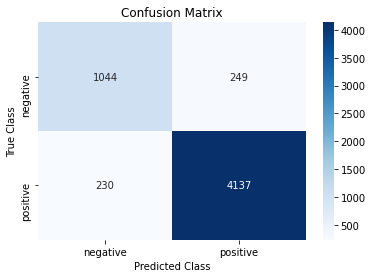

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cnf_mat = confusion_matrix(labels, y_pred)

abbreviations=['negative','positive']
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_mat, ax=ax, cmap=plt.cm.Blues, annot=True, fmt='g')
ax.set_xticklabels(abbreviations)
ax.set_yticklabels(abbreviations)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

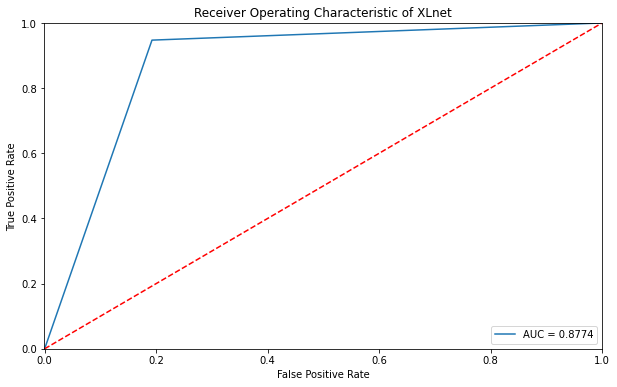

In [ ]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(labels, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic of XLnet')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();